#### Importing dependancies

In [2]:
# To fetch URLs i.e. uniform resource locators
from urllib.request import urlopen, Request

# To fetch data from HTML and/or XML files
from bs4 import BeautifulSoup

# For sentiment analysis and download vader_lexicon to measure sentiment intensity
# import nltk; nltk.download()
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby
from operator import itemgetter
from tqdm import tqdm

In [3]:
def find_missing(lst): 
    return [i for x, y in zip(lst, lst[1:])  
        for i in range(x + 1, y) if y - x > 1] 

In [36]:
tickers = ['AAPL']

finviz_url = 'https://finviz.com/quote.ashx?t='

def news_table(finviz_url, tickers):
    df = []

    news_tables = {}

    for ticker in tqdm(tickers):
        news_tables[ticker] = BeautifulSoup(urlopen(Request(url=finviz_url + ticker,
                                                            headers={"user-agent":"my-app"})),
                                            "html").find(id="news-table")



        df.append(pd.DataFrame([(row.a.get_text(), 
                                 row.td.text,
                                 ticker) for index, row in enumerate(news_tables[ticker].findAll("tr"))], 
                               columns = ["Title","Timestamp","Ticker"]))

    df = pd.concat(df).reset_index(drop=True)

    for k, g in groupby(enumerate([i for i in range(len(df["Timestamp"])) if len(df["Timestamp"][i])!=19]), 
                        lambda i_x: i_x[0] - i_x[1]):
        l = list(map(itemgetter(1), g))
        v = df.iloc[l[0]-1,:]["Timestamp"].split(" ")[0]+" "+df.iloc[l,:]["Timestamp"]
        df.iloc[l,1] = v

    df["Timestamp"] = pd.to_datetime(df["Timestamp"]).dt.date
    
    vader = SentimentIntensityAnalyzer()
    
    df["compound"] = [vader.polarity_scores(titles)["compound"] for titles in df["Title"]]
    
    return df.groupby(["Ticker","Timestamp"]).mean().unstack().xs("compound", axis="columns").transpose()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


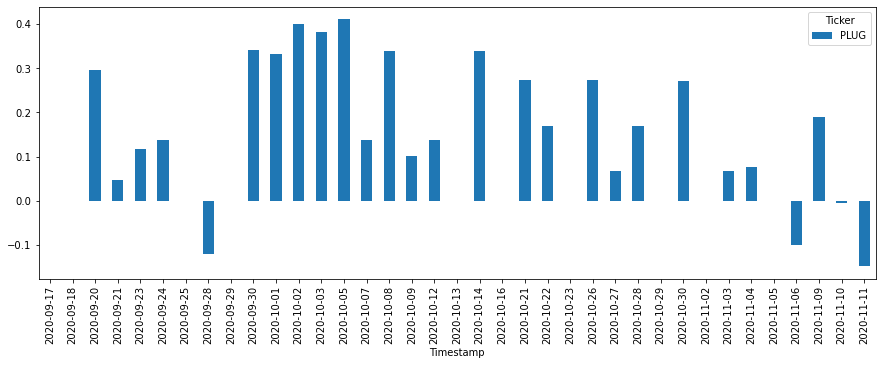

In [31]:
plt.rcParams["figure.figsize"] = (15,5)

news_table(finviz_url, ["PLUG"]).plot(kind="bar")
plt.show()

In [35]:
news_table(finviz_url, ["PLUG"])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


,Title,Timestamp,Ticker,compound
0,"Plug Power: Next Stop, $30?",2020-11-11,PLUG,-0.2960
1,Why Plug Power Stock Just Popped 10%,2020-11-11,PLUG,0.0000
2,Plug Power Is Firing on All Cylinders; Analyst...,2020-11-10,PLUG,-0.3400
3,Why Plug Power Stock Popped 6% This Morning --...,2020-11-10,PLUG,0.0000
4,Plug Powers Q3 beat leads to price-target incr...,2020-11-10,PLUG,0.3182
...,...,...,...,...
95,Plug Power To Host Virtual Plug Symposium On S...,2020-09-21,PLUG,0.0000
96,"Cramer Shares His Thoughts On Plug Power, Zebr...",2020-09-20,PLUG,0.2960
97,Why Plug Power Is Sinking to Zero While a Risi...,2020-09-18,PLUG,0.0000
98,"Why Blink Charging, Pivotal Investment, and Pl...",2020-09-18,PLUG,0.0000
